In [1]:
import pandas as pd
import h5py
from Bio import SeqIO
from copy import deepcopy 
import numpy as np
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.decomposition import PCA
import pickle
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,RocCurveDisplay
from matplotlib.colors import to_hex
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'


def load_embedding(file_name,keyset=None):
    f = h5py.File(file_name)
    Xg = []
    if keyset is None:
        gene_names = list(f.keys())
    else:
        gene_names = keyset
        
    for key in gene_names:
        Xg.append(f[key][()])
    f.close()
    Xg = pd.DataFrame(np.asmatrix(Xg),index=gene_names)
    return Xg,gene_names



def load_keys(file_name):
    f = h5py.File(file_name)
    gene_names = list(f.keys())
    f.close()
    return gene_names

In [2]:
#file = "lrmodel.l1reg.embedding2mow.pkl"
#file = "lrmodel.l2reg.embedding2mow.10Jan2023.pkl"
file = "../data/ml-models/lrmodel.l1reg.embedding2mow.18Feb2023.pkl"

with open(file,"rb") as handle:
    model = pickle.load(handle)

/Users/joshuagoldford/opt/miniconda3/envs/informatics.p38/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
#gnt = pd.read_csv("../data/sequenceTable.pterinDomains.gtdb.22Dec2022.csv",index_col=0)
gnt = pd.read_csv("../data/gtdb/pterin-binding-gene-table.csv",index_col=0)
gnt['gene name'] = gnt['gene name'].apply(lambda x: x.replace('.',"_"))
aor_seqs = gnt[gnt.KO.isin(['K03738'])]['gene name'].tolist()

In [32]:
gnt

,gene name,KO,genome
11844,JACMQD010000003_1_4,K11177,GB_GCA_014377155.1
23143,JACMQD010000004_1_12,K11177,GB_GCA_014377155.1
103317,JACMQD010000147_1_23,K07303,GB_GCA_014377155.1
106467,JACMQD010000156_1_13,K07303,GB_GCA_014377155.1
137858,JACMQD010000230_1_5,K00370,GB_GCA_014377155.1
...,...,...,...
13814,NZ_LKKK01000001_1_324,K07303,RS_GCF_001446935.1
8259,NZ_JNWO01000001_1_180,K03520,RS_GCF_000716435.1
25144,NZ_JNWO01000001_1_510,K03520,RS_GCF_000716435.1
100964,NZ_JNWO01000005_1_18,K12528,RS_GCF_000716435.1


In [4]:
# reach out to goldford@caltech.edu for this file, since it's ~1GB
f = "../data/gtdb/gtdb.pterinSeqs.embed.22Dec2022.h5"
genekeys = load_keys(f)
gkeymap = pd.DataFrame({'gene':[x.split(" ")[0] for x in genekeys],"gkey":genekeys})
gkeys = gkeymap[gkeymap.gene.isin(aor_seqs)].gkey.tolist()
pterinEmbeddingGTDB,gns = load_embedding(f,keyset=gkeys)

In [5]:
pterinEmbeddingGTDB.index = [x.split(' ')[0] for x in pterinEmbeddingGTDB.index.tolist()]
#pca_res = run_pca(pterinEmbeddingGTDB, n_components=2, normalize=False)
#pdf = pca_res["pdf"] 
#pdf = pdf.join(gnt.set_index("gene name"))

In [9]:

predictions_aorGTDB= model.predict(pterinEmbeddingGTDB)
predictions_aorGTDB = pd.DataFrame({'predict':predictions_aorGTDB},index=pterinEmbeddingGTDB.index)
predictions_aorGTDB['gene_id']= [x.split(' ')[0] for x in gns]
predictions_aorGTDB.set_index("gene_id",inplace=True)

In [11]:
aorGTDB = predictions_aorGTDB.join(gnt[gnt.KO.isin(['K03738'])].set_index("gene name"))

In [12]:
aorGTDB_mo = aorGTDB[aorGTDB.predict.isin(["Mo"])]

In [17]:

metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
# get ncbi taxa ids for gtdb genomes
archaea = pd.read_csv("../data/gtdb/ar53_metadata_r207.tsv",sep='\t')
archaea = archaea[['accession','ncbi_taxid']]

bacteria = pd.read_csv("../data/gtdb/bac120_metadata_r207.tsv",sep='\t')
bacteria = bacteria[['accession','ncbi_taxid']]

archaea['domain'] = "Archaea"
bacteria['domain'] = "Bacteria"

gtdb_to_ncbi = pd.concat([archaea,bacteria],axis=0)

aorGTDB_ncbi = aorGTDB.reset_index().set_index("genome").join(gtdb_to_ncbi.set_index("accession"))

aorGTDB_ncbi = aorGTDB_ncbi.reset_index().set_index('ncbi_taxid').join(metadata.set_index("NCBI_TAXONOMY_ID"))
aorGTDB_ncbi = aorGTDB_ncbi.drop_duplicates()


possible = ['Obligate aerobe', 'Aerobe',"Anaerobe",'Obligate anaerobe']
aorGTDB_ncbi_sub = aorGTDB_ncbi[aorGTDB_ncbi.OXYGEN_REQUIREMENT.isin(possible)]

#aerobe = ['Obligate aerobe', 'Aerobe',"Microaerophilic","Facultative","Facultative anaerobe"]
#df2['o2_tol']= df2["OXYGEN_REQUIREMENT"].isin(aerobe)
aerobe = ['Obligate aerobe', 'Aerobe']
aorGTDB_ncbi_sub['o2_tol']= aorGTDB_ncbi_sub["OXYGEN_REQUIREMENT"].isin(aerobe)

glabel = {}
glabel[True] = 'Aerobe'
glabel[False] = 'Anaerobe'

aorGTDB_ncbi_sub['physiology'] = aorGTDB_ncbi_sub["o2_tol"].apply(lambda x: glabel[x])



/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_33944/4156763976.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_33944/4156763976.py:6: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bacteria = pd.read_csv("../data/gtdb/bac120_metadata_r207.tsv",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_33944/4156763976.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aorGTDB_ncbi_sub['o2_tol']= aorGTDB_ncbi_sub["OXYGEN_REQUIREMENT"].isin

In [18]:
aorGTDB_ncbi_sub

,index,gene_id,predict,KO,domain,GOLD_ORGANISM_ID,ORGANISM_NAME,GENUS,SPECIES,STRAIN,...,TEMPERATURE_RANGE,BIOTIC_RELATIONSHIP,SYMBIOTIC_RELATIONSHIP,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM,o2_tol,physiology
24,RS_GCF_016406305.1,NZ_CP066369_1_1113,W,K03738,Bacteria,6538.0,Shewanella putrefaciens W3-6-1,Shewanella,Shewanella putrefaciens,W3-6-1,...,Mesophile,Free living,(null),Host-associated,(null),(null),(null),(null),False,Anaerobe
24,RS_GCF_016406325.1,NZ_CP066370_1_1106,W,K03738,Bacteria,6538.0,Shewanella putrefaciens W3-6-1,Shewanella,Shewanella putrefaciens,W3-6-1,...,Mesophile,Free living,(null),Host-associated,(null),(null),(null),(null),False,Anaerobe
52,RS_GCF_001189295.1,NZ_CP012159_1_5949,W,K03738,Bacteria,4383.0,Chondromyces crocatus KYC2823,Chondromyces,Chondromyces crocatus,KYC2823,...,(null),Free living,(null),Environmental,Terrestrial,Soil,Unclassified,Unclassified,True,Aerobe
274,GB_GCA_002355995.1,AP017920_1_1018,W,K03738,Bacteria,2120.0,Thermus thermophilus,Thermus,Thermus thermophilus,(null),...,Thermophile,Free living,(null),Environmental,Aquatic,Marine,Hydrothermal vents,Unclassified,True,Aerobe
274,GB_GCA_002355995.1,AP017920_1_1216,W,K03738,Bacteria,2120.0,Thermus thermophilus,Thermus,Thermus thermophilus,(null),...,Thermophile,Free living,(null),Environmental,Aquatic,Marine,Hydrothermal vents,Unclassified,True,Aerobe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750597,RS_GCF_003751635.1,NZ_RJVI01000002_1_645,W,K03738,Bacteria,402678.0,Inmirania thermothiophila DSM 100275,Inmirania,Inmirania thermothiophila,DSM 100275,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe
1773489,RS_GCF_004341725.1,NZ_SLZW01000003_1_102,W,K03738,Bacteria,402712.0,Varunaivibrio sulfuroxidans DSM 101688,Varunaivibrio,Varunaivibrio sulfuroxidans,DSM 101688,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe
1835254,RS_GCF_000973625.1,NZ_CP007501_1_181,W,K03738,Bacteria,9907.0,Polynucleobacter duraquae MWH-MoK4,Polynucleobacter,Polynucleobacter duraquae,MWH-MoK4,...,Mesophile,Free living,(null),Environmental,Aquatic,Freshwater,Lentic,Unclassified,True,Aerobe
1894989,RS_GCF_003815015.1,NZ_RKRE01000001_1_643,W,K03738,Bacteria,402742.0,Thermodesulfitimonas autotrophica DSM 102936,Thermodesulfitimonas,Thermodesulfitimonas autotrophica,DSM 102936,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe


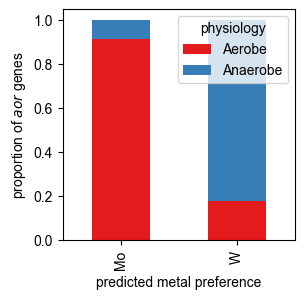

In [19]:

X = pd.crosstab(aorGTDB_ncbi_sub['predict'],aorGTDB_ncbi_sub['physiology'])
Xn = X.apply(lambda x: x/x.sum(),axis=1)

Xn.plot(kind='bar', stacked=True, color=sns.color_palette(palette='Set1',n_colors=2),figsize=(3,3))
plt.ylabel("proportion of $aor$ genes")
plt.xlabel("predicted metal preference")
plt.savefig("AOR.predictedPreference.OxygenTolerance.svg")
